# Preparation

In [1]:
!pip install sktime
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from google.colab import drive
import sktime
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define Paths
DATA_DIR = "/content/drive/Shared drives/github/divvy_demand_forecast/data"

ValueError: mount failed

## Loading Data

In [ ]:
data_raw = pd.read_parquet(os.path.join(DATA_DIR, "divvy_daily_ridership_station.parquet"))
print(data_raw.shape)
data_raw.head()

In [ ]:
# Load training and test data
rides_by_date = data_raw.groupby(["start_station_name","date"])["total_rides"].sum().reset_index()
rides_by_date["year"] = rides_by_date["date"].dt.year
df = rides_by_date[rides_by_date["year"]<2024]
df.head()

## Data Preprocessing and EDA

In [ ]:
df.loc[df["year"].isin([2020])]["start_station_name"].nunique()

In [ ]:
df.loc[df["year"].isin([2021])]["start_station_name"].nunique()

In [ ]:
df.loc[df["year"].isin([2022])]["start_station_name"].nunique()

In [ ]:
df.loc[df["year"].isin([2023])]["start_station_name"].nunique()

In [ ]:
df_2022 = df.loc[df["year"].isin([2021])]
station_df = df_2022[["date", "start_station_name", "total_rides"]].groupby(["date", "start_station_name"]).sum().reset_index()
top_stations = station_df.groupby(["start_station_name"])["total_rides"].sum().reset_index().sort_values("total_rides", ascending=False)
top_stations.set_index("start_station_name", inplace=True)
plt.plot(range(0, len(top_stations)), top_stations["total_rides"])
# top_stations

### Subset the number of stations needed to account for at least 50% of total rides in 2023

In [ ]:
filtered_df = df.loc[df["year"].isin([2021])]

total_rides = top_stations["total_rides"].iloc[1:].sum()
indices = []
stations = []
ride_percent = 0
idx = 0

for station in top_stations.index[:501]:

    station_days = len(filtered_df.loc[filtered_df["start_station_name"] == station])
    missing_days = 365 - station_days
    if missing_days > 365 * 0.05:
        print(f"Excluded: {station} - only {station_days} days of data (missing {missing_days} days)")
    else:
        indices.append(idx)
        stations.append(station)
        if idx >= 1:
            ride_percent = top_stations["total_rides"].iloc[1:idx+1].sum() / total_rides
    idx += 1

top100 = station_df.loc[station_df["start_station_name"].isin(stations)]
top100["date"] = pd.to_datetime(top100["date"])

print(len(stations))
print(ride_percent)

### Interpolate missing data and normalize

In [ ]:
import numpy as np
import pandas as pd

full_dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
date_df = pd.DataFrame(index=full_dates)

ts_sample = np.empty((0, 365))

for station in top100["start_station_name"].unique():
    temp_df = top100.loc[top100["start_station_name"] == station].loc[top100["date"].dt.year.isin([2021])]

    df_complete = date_df.join(temp_df.set_index('date'), how='left')

    if pd.isna(df_complete["total_rides"].iloc[0]):
        first_valid_idx = df_complete["total_rides"].first_valid_index()
        if first_valid_idx is not None:
            first_valid_value = df_complete.loc[first_valid_idx, "total_rides"]
            df_complete.loc[df_complete.index[0], "total_rides"] = first_valid_value

    if df_complete["total_rides"].isna().any():
        df_complete["total_rides"] = df_complete["total_rides"].fillna(method='ffill')
        df_complete["total_rides"] = df_complete["total_rides"].fillna(method='bfill')

    ts_sample = np.vstack([ts_sample, df_complete["total_rides"].values.reshape(1, -1)])

def z_normalize(ts_array):
    normalized = np.empty_like(ts_array, dtype=np.float64)
    for i, ts in enumerate(ts_array):
        std = np.std(ts)
        if std > 0:
            normalized[i] = (ts - np.mean(ts)) / std
        else:
            print(ts)
    return normalized

ts_normalized = z_normalize(ts_sample)

import matplotlib.pyplot as plt
plt.plot(ts_normalized)
plt.show()

### Dynamic Time Warping Example with first 2 time series observations

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

path = dtw.warping_path(ts_normalized[0], ts_normalized[1])
dtwvis.plot_warping(ts_normalized[0], ts_normalized[1], path)

## Model Building and Hyperparameter Tuning

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, linkage
from scipy.spatial.distance import squareform

ts_sample = ts_normalized.astype(np.double)
distance_matrix = dtw.distance_matrix_fast(ts_normalized)

distance_matrix[~np.isfinite(distance_matrix)] = np.max(distance_matrix[np.isfinite(distance_matrix)])

condensed_dist = squareform(distance_matrix)

linkage_matrix = linkage(condensed_dist, method='complete')

silhouette_scores = []
range_n_clusters = range(3, 15)

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'b-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.axhline(y=np.median(linkage_matrix[:, 2]), color='r', linestyle='--')
plt.show()

In [ ]:
# Calculate WCSS for different numbers of clusters
wcss = []
range_n_clusters = range(1, 15)

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    current_wcss = 0

    # Calculate WCSS using DTW distances
    for i in range(1, n_clusters + 1):
        cluster_indices = np.where(cluster_labels == i)[0]
        if len(cluster_indices) > 1:
            # Get pairwise distances within this cluster
            cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
            # Sum of squared distances to cluster center (approximated as mean of distances)
            current_wcss += np.sum(cluster_distances) / (2 * len(cluster_indices))

    wcss.append(current_wcss)

# Plot WCSS
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, 'b-o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.show()

# Optimal Model Buidling

In [ ]:
n_clusters = 4
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(1, n_clusters + 1):
    cluster_members = ts_normalized[cluster_labels == i]
    plt.subplot(n_clusters, 1, i)
    plt.plot(cluster_members.T, alpha=0.5)
    plt.title(f'Cluster {i} (n={len(cluster_members)})')
plt.tight_layout()
plt.show()

## Process and Visualize Results

In [ ]:
cluster_df = pd.DataFrame({"start_station_name": top100["start_station_name"].unique(), "cluster": cluster_labels})

In [ ]:
cluster_df.to_csv(os.path.join(DATA_DIR, "2021_cluster_df.csv"), index=False)

In [ ]:
expanded_df = pd.read_parquet(os.path.join(DATA_DIR,"divvy_ridership_raw.parquet"))
expanded_df.head()

,ride_id,rideable_type,started_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,date
0,EACB19130B0CDA4A,docked_bike,2020-01-21 20:06:59,Western Ave & Leland Ave,239,Clark St & Leland Ave,326,member,2020-01-21
1,8FED874C809DC021,docked_bike,2020-01-30 14:22:39,Clark St & Montrose Ave,234,Southport Ave & Irving Park Rd,318,member,2020-01-30
2,789F3C21E472CA96,docked_bike,2020-01-09 19:29:26,Broadway & Belmont Ave,296,Wilton Ave & Belmont Ave,117,member,2020-01-09
3,C9A388DAC6ABF313,docked_bike,2020-01-06 16:17:07,Clark St & Randolph St,51,Fairbanks Ct & Grand Ave,24,member,2020-01-06
4,943BC3CBECCFD662,docked_bike,2020-01-30 08:37:16,Clinton St & Lake St,66,Wells St & Hubbard St,212,member,2020-01-30


In [ ]:
coordinate_df = expanded_df.loc[expanded_df["start_station_name"].isin(top100["start_station_name"].unique())].groupby(["start_station_name", "start_lat", "start_lng"]).count().reset_index()
avg_coord_df = coordinate_df.groupby("start_station_name").mean().reset_index()[["start_station_name", "start_lat", "start_lng"]]
cluster_coord_df = avg_coord_df.merge(cluster_df, on="start_station_name", how="left")

In [ ]:
import pandas as pd
import folium

# Assuming your dataframe is called 'stations_df' with columns 'name', 'latitude', and 'longitude'
# If your dataframe has different column names, adjust accordingly

# Create a map centered on Chicago
chicago_coords = [41.8781, -87.6298]  # Chicago's approximate center coordinates
chicago_map = folium.Map(location=chicago_coords, zoom_start=12)

# Add markers for each station
for idx, row in cluster_coord_df.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        tooltip=row['start_station_name']
    ).add_to(chicago_map)

# Save the map to an HTML file
chicago_map.save('chicago_divvy_stations.html')

# Display the map in a Jupyter notebook (if you're using one)
chicago_map

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Assuming your dataframe is called 'stations_df' with columns 'name', 'latitude', 'longitude', and 'cluster'

# Create a map centered on Chicago
chicago_coords = [41.8781, -87.6298]
chicago_map = folium.Map(location=chicago_coords, zoom_start=12)

# Define colors for each cluster
# Using 5 distinct colors that are visually distinguishable
cluster_colors = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'purple',
}

# If your clusters are named differently (like 'A', 'B', 'C', etc.), adjust the dictionary keys accordingly

# Add markers for each station with color based on cluster
for idx, row in cluster_coord_df.iterrows():
    # Get the appropriate color for this cluster
    cluster_id = row['cluster']
    color = cluster_colors.get(cluster_id, 'gray')  # Default to gray if cluster not in our dictionary

    # Create a marker with the cluster-specific color
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'] + f" (Cluster: {cluster_id})",
        tooltip=row['start_station_name'],
        icon=folium.Icon(color=color)
    ).add_to(chicago_map)

# Add a legend (as a simple HTML element)
legend_html = '''
<div style="position: fixed;
     bottom: 50px; right: 50px; width: 150px; height: 160px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;
     ">
     <b>Cluster Legend</b><br>
     <i class="fa fa-map-marker fa-2x" style="color:red"></i> Cluster 1<br>
     <i class="fa fa-map-marker fa-2x" style="color:blue"></i> Cluster 2<br>
     <i class="fa fa-map-marker fa-2x" style="color:green"></i> Cluster 3<br>
     <i class="fa fa-map-marker fa-2x" style="color:purple"></i> Cluster 4<br>
     <i class="fa fa-map-marker fa-2x" style="color:orange"></i> Cluster 5
</div>
'''
chicago_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
chicago_map.save('chicago_divvy_stations_clustered.html')

# Display the map in a Jupyter notebook (if you're using one)
chicago_map

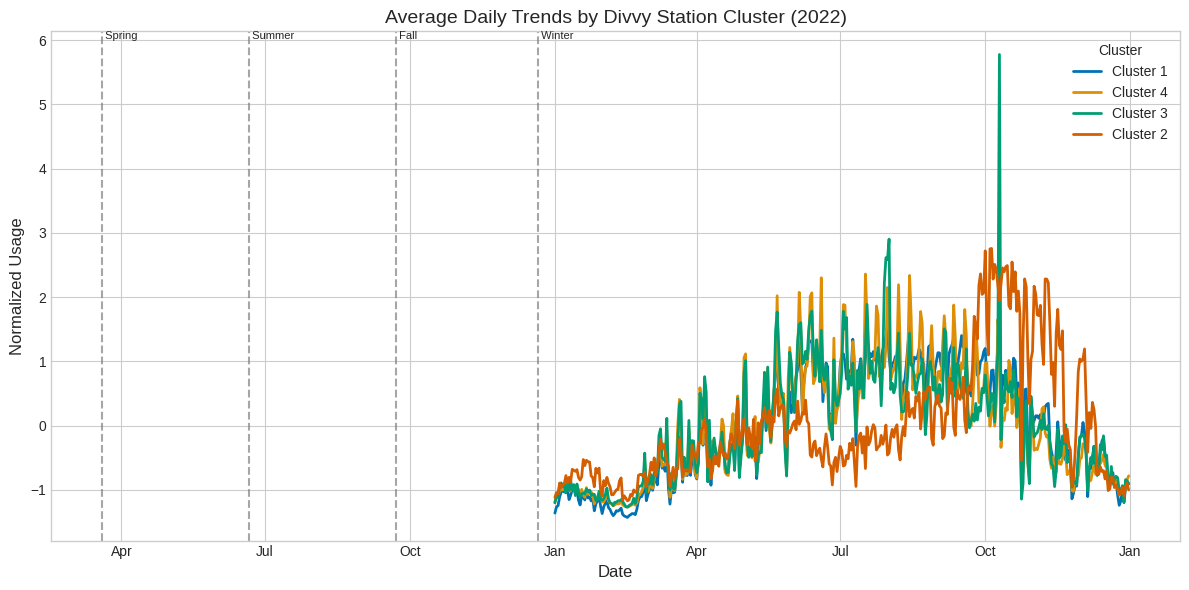

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime as dt

# Assuming:
# - ts_normalized is your numpy array with shape (89, 365)
# - cluster_df is your dataframe with station-to-cluster mapping

# Set up the plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# 1. Generate date range for the x-axis (assuming 2022)
dates = [dt.datetime(2023, 1, 1) + dt.timedelta(days=i) for i in range(365)]

# 2. Calculate average trend for each cluster
unique_clusters = cluster_df['cluster'].unique()

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# For each cluster, calculate and plot the average trend
for cluster_id in unique_clusters:
    # Get indices of stations in this cluster
    station_indices = cluster_df[cluster_df['cluster'] == cluster_id].index.tolist()

    # Extract time series data for these stations
    cluster_ts = ts_normalized[station_indices, :]

    # Calculate daily average across all stations in this cluster
    cluster_avg = np.mean(cluster_ts, axis=0)

    # Plot the average trend for this cluster
    ax.plot(dates, cluster_avg, linewidth=2, label=f'Cluster {cluster_id}')

# Add labels and legend
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Usage', fontsize=12)
ax.set_title('Average Daily Trends by Divvy Station Cluster (2022)', fontsize=14)

# Format the x-axis to show months
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

# Add legend
ax.legend(title="Cluster")

# Optional: Add annotations or vertical lines for seasons/holidays
spring_start = dt.datetime(2022, 3, 20)
summer_start = dt.datetime(2022, 6, 21)
fall_start = dt.datetime(2022, 9, 22)
winter_start = dt.datetime(2022, 12, 21)

for season_start, season_name in [
    (spring_start, 'Spring'),
    (summer_start, 'Summer'),
    (fall_start, 'Fall'),
    (winter_start, 'Winter')
]:
    ax.axvline(x=season_start, color='gray', linestyle='--', alpha=0.7)
    ax.text(season_start, ax.get_ylim()[1], f' {season_name}',
            verticalalignment='top', horizontalalignment='left', fontsize=8)

plt.tight_layout()
plt.show()

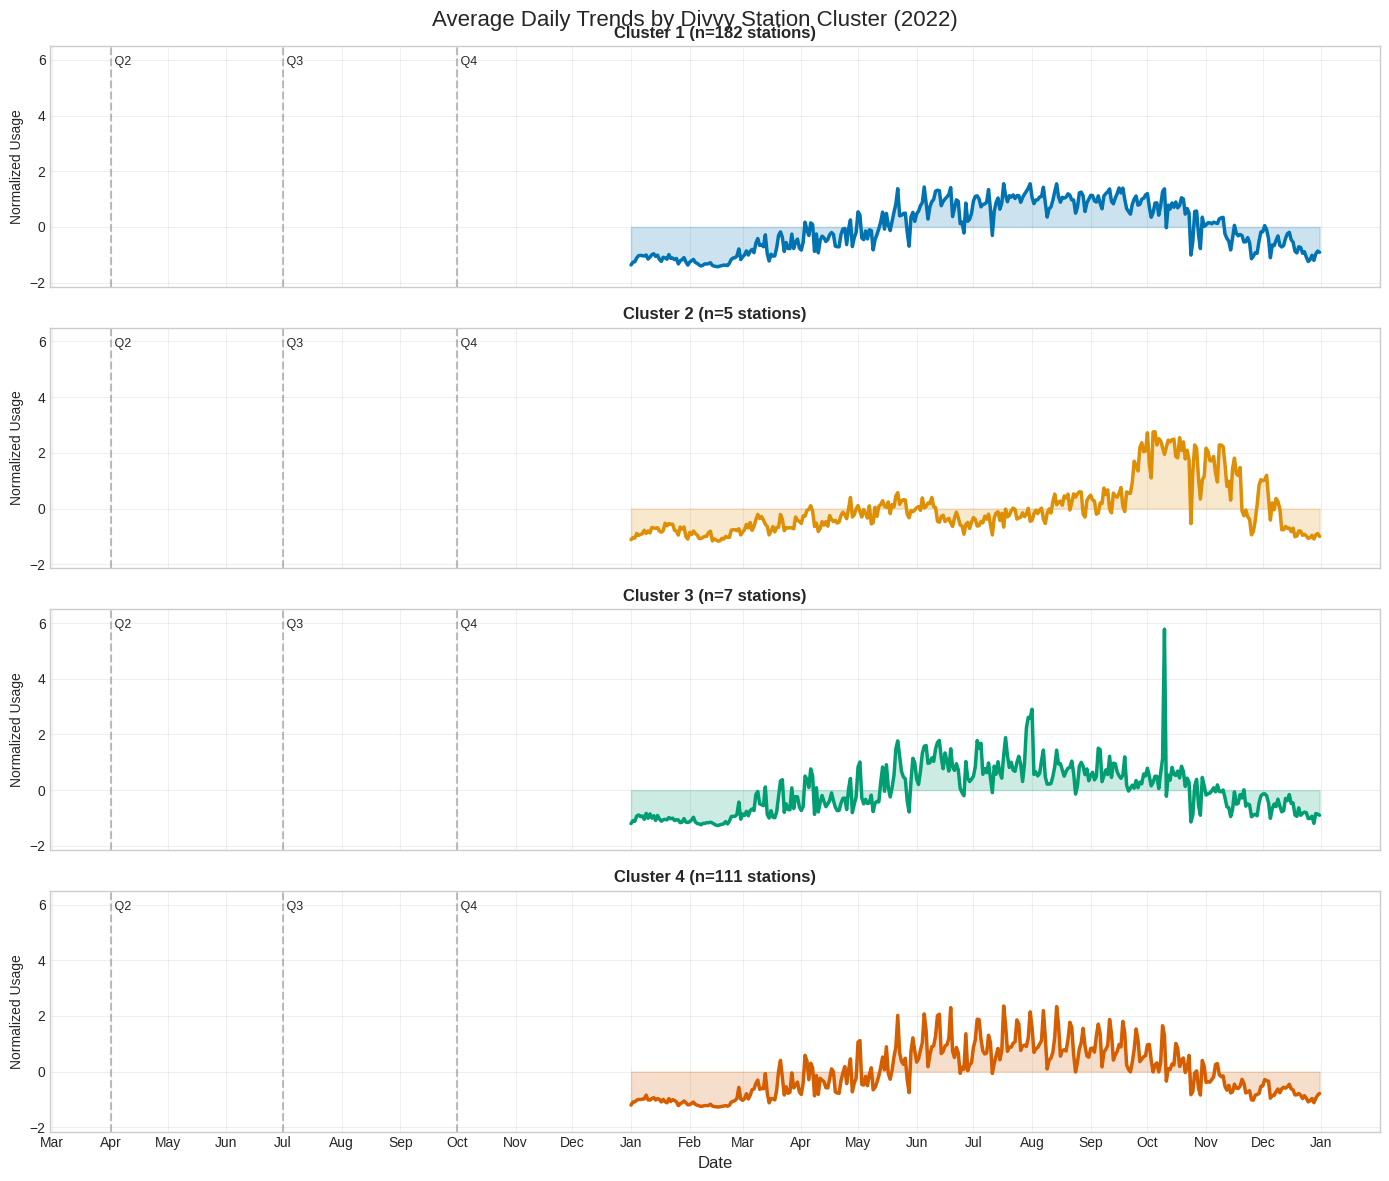

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns

# Assuming:
# - ts_normalized is your numpy array with shape (89, 365)
# - cluster_df is your dataframe with station-to-cluster mapping

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')

# Generate date range for the x-axis (assuming 2022)
dates = [dt.datetime(2023, 1, 1) + dt.timedelta(days=i) for i in range(365)]

# Identify unique clusters and sort them
unique_clusters = sorted(cluster_df['cluster'].unique())

# Create the figure with one subplot per cluster
fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(14, 3*len(unique_clusters)), sharex=True)

# Set a consistent y-axis limit for comparison
y_min, y_max = float('inf'), float('-inf')

# First pass: calculate all cluster averages and determine global y-limits
cluster_avgs = {}
for cluster_id in unique_clusters:
    # Get indices of stations in this cluster
    station_indices = cluster_df[cluster_df['cluster'] == cluster_id].index.tolist()

    # Extract time series data for these stations
    cluster_ts = ts_normalized[station_indices, :]

    # Calculate daily average across all stations in this cluster
    cluster_avg = np.mean(cluster_ts, axis=0)
    cluster_avgs[cluster_id] = cluster_avg

    # Update global y-limits
    y_min = min(y_min, np.min(cluster_avg))
    y_max = max(y_max, np.max(cluster_avg))

# Add some padding to y-limits
y_padding = (y_max - y_min) * 0.1
y_min -= y_padding
y_max += y_padding

# Second pass: plot each cluster in its own subplot
for i, cluster_id in enumerate(unique_clusters):
    ax = axes[i]
    cluster_avg = cluster_avgs[cluster_id]

    # Count stations in this cluster for the title
    station_count = sum(cluster_df['cluster'] == cluster_id)

    # Plot the average trend for this cluster
    line = ax.plot(dates, cluster_avg, linewidth=2.5, color=f'C{i}')

    # Add a filled area below the line to make it more visible
    ax.fill_between(dates, 0, cluster_avg, alpha=0.2, color=line[0].get_color())

    # Set the y-limits to be consistent across all subplots
    ax.set_ylim(y_min, y_max)

    # Set titles and labels
    ax.set_title(f'Cluster {cluster_id} (n={station_count} stations)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Normalized Usage', fontsize=10)

    # Add grid
    ax.grid(True, alpha=0.3)

    # Add year quarter markers
    for month in [4, 7, 10]:  # April, July, October
        quarter_date = dt.datetime(2022, month, 1)
        ax.axvline(x=quarter_date, color='gray', linestyle='--', alpha=0.5)
        quarter_num = ((month-1)//3) + 1
        ax.text(quarter_date, y_max - y_padding*0.5, f' Q{quarter_num}',
                verticalalignment='top', fontsize=9)

# Set up the x-axis format for the bottom subplot only
axes[-1].set_xlabel('Date', fontsize=12)
axes[-1].xaxis.set_major_locator(mdates.MonthLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Add an overall title
fig.suptitle('Average Daily Trends by Divvy Station Cluster (2022)', fontsize=16, y=0.98)

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the overall title

# Show the plot
plt.show()

# Optionally save the figure
# plt.savefig('divvy_cluster_faceted_trends.png', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Assuming your dataframe is called 'cluster_coord_df' with columns 'start_station_name', 'start_lat', 'start_lng', and 'cluster'

# Create a map centered on Chicago
chicago_coords = [41.8781, -87.6298]
chicago_map = folium.Map(location=chicago_coords, zoom_start=11)

# Define colors for each cluster
# Using highly distinguishable colors with high contrast
cluster_colors = {
    1: '#FF00FF',  # Magenta
    2: '#FF0000',  # Bright red
    3: '#00CC00',  # Bright green
    4: '#0070FF',  # Strong blue
}

cluster_icons = {
    1: 'star',
    2: 'info-sign',
    3: 'ok-sign',
    4: 'flag',
}

# Create a feature group for each cluster to allow toggling on/off
cluster_groups = {i: folium.FeatureGroup(name=f"Cluster {i}") for i in range(1, 5)}

# Add markers for each station with color and icon based on cluster
for idx, row in cluster_coord_df.iterrows():
    # Get the appropriate color and icon for this cluster
    cluster_id = row['cluster']
    color = cluster_colors.get(cluster_id, 'gray')  # Default to gray if cluster not in our dictionary
    icon_type = cluster_icons.get(cluster_id, 'map-marker')

    # Create a marker with the cluster-specific color and icon
    # Use CircleMarker instead of Marker for a smaller footprint
    marker = folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=4,  # Small circle radius
        popup=f"<b>{row['start_station_name']}</b><br>Cluster: {cluster_id}",
        tooltip=row['start_station_name'],
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=1
    )

    # Add the marker to its cluster group
    marker.add_to(cluster_groups[cluster_id])

# Add all feature groups to the map
for group in cluster_groups.values():
    group.add_to(chicago_map)

# Add layer control to toggle clusters on/off
folium.LayerControl().add_to(chicago_map)

legend_html = '''
<div style="position: fixed;
     bottom: 50px; right: 50px; width: 250px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;
     border-radius: 5px; box-shadow: 0 0 15px rgba(0,0,0,0.2);
     ">
     <div style="text-align: center;"><b>Divvy Station Clusters</b></div>
     <hr style="margin: 10px 0px;">
     <div><svg height="10" width="10"><circle cx="5" cy="5" r="4" fill="red" /></svg> <span style="padding-left:10px;">Cluster 1 - Peripheral</span></div><br>
     <div><svg height="10" width="10"><circle cx="5" cy="5" r="4" fill="blue" /></svg> <span style="padding-left:10px;">Cluster 2 - College Campuses</span></div><br>
     <div><svg height="10" width="10"><circle cx="5" cy="5" r="4" fill="green" /></svg> <span style="padding-left:10px;">Cluster 3 - Work Centers</span></div><br>
     <div><svg height="10" width="10"><circle cx="5" cy="5" r="4" fill="purple" /></svg> <span style="padding-left:10px;">Cluster 4 - Neighborhoods & Lakefront</span></div>
</div>
'''
chicago_map.get_root().html.add_child(folium.Element(legend_html))

# Instead of HeatMap, use CircleMarkers to show density
# Create circle marker overlays for each cluster to show density
for cluster_id in range(1, 5):
    cluster_data = cluster_coord_df[cluster_coord_df['cluster'] == cluster_id]

    # Create a feature group for density visualization
    density_group = folium.FeatureGroup(name=f'Cluster {cluster_id} Density')

    # Add semi-transparent circles at each station location
    for idx, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['start_lat'], row['start_lng']],
            radius=15,  # Reduced size of circle
            color=cluster_colors[cluster_id],
            fill=True,
            fill_color=cluster_colors[cluster_id],
            fill_opacity=0.15,  # More transparent
            weight=1,
            opacity=0.4
        ).add_to(density_group)

    # Add the density group to the map
    density_group.add_to(chicago_map)

# Save the map to an HTML file
chicago_map.save('chicago_divvy_stations_clustered.html')

# Display the map in a Jupyter notebook (if you're using one)
chicago_map

## Building Cluster Level Models

In [ ]:
stations_with_clusters = df.loc[df["start_station_name"].isin(cluster_df['start_station_name'])]
stations_with_clusters = stations_with_clusters.merge(cluster_df, on="start_station_name", how="left")

In [ ]:
cluster_series_df = stations_with_clusters[["date", "cluster", "total_rides"]].groupby(["date", "cluster"]).sum().reset_index()
cluster_series_df

,date,cluster,total_rides
0,2020-01-01,1,81
1,2020-01-01,2,698
2,2020-01-01,3,204
3,2020-01-01,4,17
4,2020-01-02,1,925
...,...,...,...
5830,2023-12-30,4,52
5831,2023-12-31,1,98
5832,2023-12-31,2,833
5833,2023-12-31,3,231


In [ ]:
test_df = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_test.csv")

In [ ]:
test_stations = test_df.loc[test_df["start_station_name"].isin(cluster_df['start_station_name'])]
test_stations = test_stations.merge(cluster_df, on="start_station_name", how="left")

In [ ]:
test_cluster_df = test_stations[["date", "cluster", "total_rides"]].groupby(["date", "cluster"]).sum().reset_index()
test_cluster_df

,date,cluster,total_rides
0,2024-01-01,1,107
1,2024-01-01,2,42
2,2024-01-01,3,673
3,2024-01-01,4,605
4,2024-01-02,1,585
...,...,...,...
1583,2025-01-30,4,1185
1584,2025-01-31,1,298
1585,2025-01-31,2,159
1586,2025-01-31,3,494


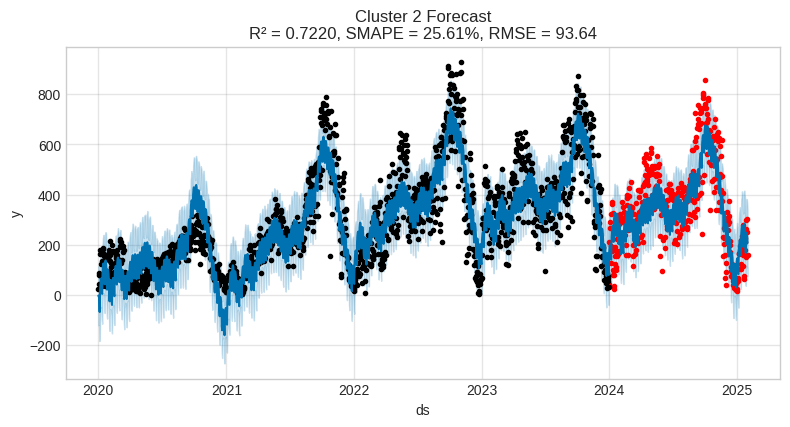

Cluster 2 Metrics:
  R-squared: 0.7220
  SMAPE: 25.61%
  MAPE: 39.71%
  RMSE: 93.64
  MPE: -0.22%
-----------------------------------


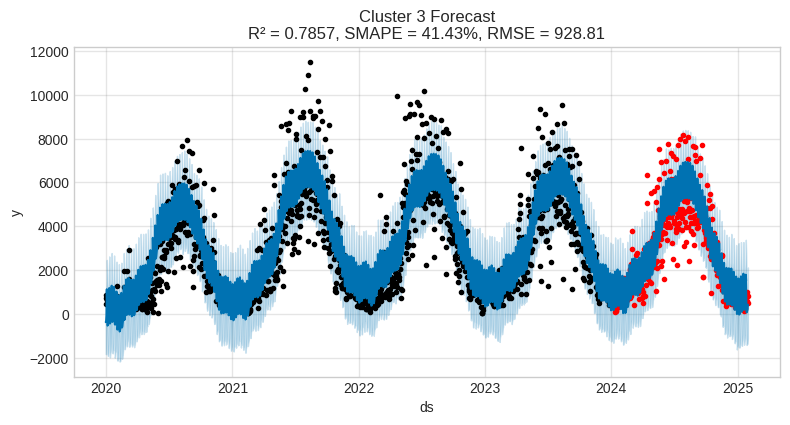

Cluster 3 Metrics:
  R-squared: 0.7857
  SMAPE: 41.43%
  MAPE: 46.45%
  RMSE: 928.81
  MPE: -0.11%
-----------------------------------


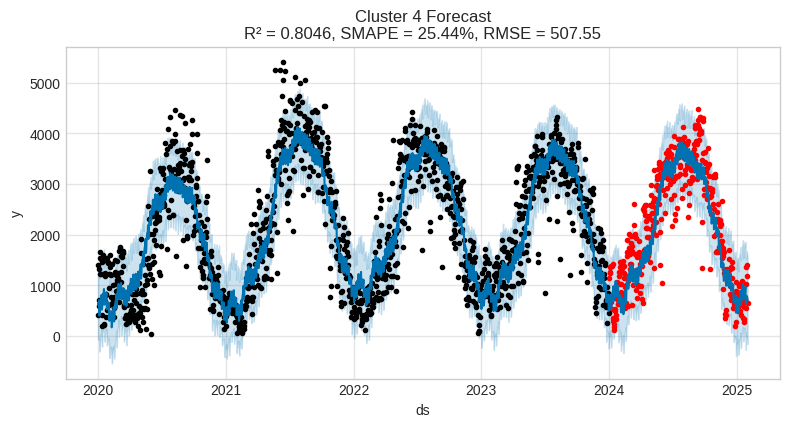

Cluster 4 Metrics:
  R-squared: 0.8046
  SMAPE: 25.44%
  MAPE: 29.82%
  RMSE: 507.55
  MPE: -0.06%
-----------------------------------


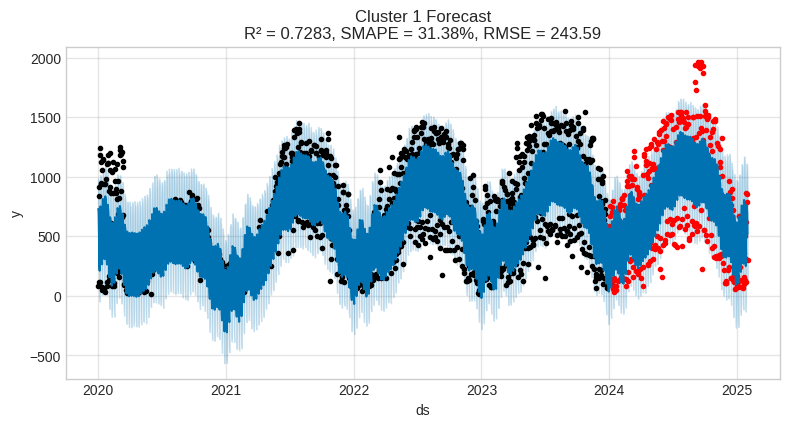

Cluster 1 Metrics:
  R-squared: 0.7283
  SMAPE: 31.38%
  MAPE: 50.22%
  RMSE: 243.59
  MPE: -0.34%
-----------------------------------


In [ ]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import logging
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Suppress Prophet and cmdstanpy logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Create dictionaries to store different metrics
cluster_errors = {}
cluster_r2_scores = {}
cluster_smape_scores = {}
cluster_mape_scores = {}
cluster_rmse_scores = {}

# Function to calculate SMAPE (Symmetric Mean Absolute Percentage Error)
def calculate_smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

# Function to calculate RMSE (Root Mean Squared Error)
def calculate_rmse(actual, forecast):
    return np.sqrt(np.mean((forecast - actual) ** 2))

for cluster in stations_with_clusters["cluster"].unique():
    y_train_cluster = cluster_series_df.loc[cluster_series_df["cluster"] == cluster].reset_index().rename(columns={"date": "ds", "total_rides": "y"})
    y_test_cluster = test_cluster_df.loc[test_cluster_df["cluster"] == cluster].reset_index().rename(columns={"date": "ds", "total_rides": "y"})
    y_test_cluster["ds"] = pd.to_datetime(y_test_cluster["ds"])

    model = Prophet()

    try:
        # Fit the model
        model.fit(y_train_cluster)

        # Make future predictions
        future_data = model.make_future_dataframe(periods=len(y_test_cluster), freq='d')
        forecast_data = model.predict(future_data)

        # Merge forecast with actual test values
        merge_forecast = forecast_data.merge(y_test_cluster, on="ds")

        # Calculate MPE (Mean Percentage Error)
        merge_forecast["MPE"] = (merge_forecast.y - merge_forecast.yhat) / merge_forecast.y

        # Extract test period predictions (last 'n' days)
        test_predictions = merge_forecast.tail(len(y_test_cluster))

        # Calculate R-squared
        r2 = r2_score(test_predictions.y, test_predictions.yhat)

        # Calculate SMAPE
        smape = calculate_smape(test_predictions.y, test_predictions.yhat)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((test_predictions.y - test_predictions.yhat) / test_predictions.y)) * 100

        # Calculate RMSE
        rmse = calculate_rmse(test_predictions.y, test_predictions.yhat)

        # Store metrics
        cluster_errors[cluster] = merge_forecast["MPE"].mean()
        cluster_r2_scores[cluster] = r2
        cluster_smape_scores[cluster] = smape
        cluster_mape_scores[cluster] = mape
        cluster_rmse_scores[cluster] = rmse

        # Plot the results
        p = model.plot(forecast_data, figsize=(8,4))
        plt.scatter(pd.to_datetime(y_test_cluster.ds), pd.to_numeric(y_test_cluster.y), color='r', marker='.')
        plt.title(f"Cluster {cluster} Forecast\nR² = {r2:.4f}, SMAPE = {smape:.2f}%, RMSE = {rmse:.2f}")
        plt.show()

        # Print metrics summary for this cluster
        print(f"Cluster {cluster} Metrics:")
        print(f"  R-squared: {r2:.4f}")
        print(f"  SMAPE: {smape:.2f}%")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MPE: {cluster_errors[cluster]:.2f}%")
        print("-----------------------------------")

    except Exception as e:
        print(f"Cluster {cluster} failed to train. Error: {str(e)}")

# Create a DataFrame with all metrics for comparison
metrics_df = pd.DataFrame({
    'Cluster': list(cluster_errors.keys()),
    'R-squared': [cluster_r2_scores.get(c, np.nan) for c in cluster_errors.keys()],
    'SMAPE (%)': [cluster_smape_scores.get(c, np.nan) for c in cluster_errors.keys()],
    'MAPE (%)': [cluster_mape_scores.get(c, np.nan) for c in cluster_errors.keys()],
    'RMSE': [cluster_rmse_scores.get(c, np.nan) for c in cluster_errors.keys()],
    'MPE (%)': [cluster_errors.get(c, np.nan) for c in cluster_errors.keys()]
})